**Author:** Prof. AJ Smit

Department of Biodiversity and Conservation Biology

University of the Western Cape

# Topic 13: Cluster analysis

In this example we will apply two types of cluster analyses, viz. **K-means clustering** and **hierarchical clustering**. Whereas ordination attempts to display the presence and influence of gradients, clustering tries to place our samples into a certain number of discrete units or clusters. We have seen that the seaweed data seem to form a conituum of species and environmental properties from west to east around the SA coastline. Seaweed biologists have classified this continuous landscape into bioregions, which make sense from a detailed understanding of the nature of the landscape and ocean features in the country. Can our classifications (e.g. Bolton and Anderson, 2004; Smit et al., 2017) be supported by numerical classifications of the coastal environmental characteristics? This example will explore this question.

Additional examples of clustering to study are:

1. Numerical Ecology in R, pp. 53-62. Later pages in the Cluster chapter go deeper into clustering and you should read over it for a broad overview. For the purpose of this module, we will focus on 4.3 Hierarchical Clustering and 4.4 Agglomerative Clustering.
2. A [Kaggle challenge](https://www.kaggle.com/rohan0301/unsupervised-learning-on-country-data) with examples of both Hierarchical Clustering and K-means Clustering.

## Set-up the analysis environment

In [1]:
library(tidyverse) 
library(GGally)
library(cluster)
library(dendextend)
library(ggcorrplot)
library(factoextra)
library(gridExtra)
library(vegan)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


---------------------
Welcome to dendextend version 1.15.1
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To 

## The seaweed environmental data

Load the data and examine it:

In [3]:
load("/Users/ajsmit/Dropbox/R/workshops/Quantitative_Ecology/exercises/diversity/SeaweedEnv.RData")
head(env)
dim(env)

,febMean,febMax,febMed,febX95,febRange,augMean,augMin,augMed,augX5,augRange,annMean,annSD,annRange,febSD,augSD,annChl,augChl,febChl
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,13.00117,18.72044,12.66004,16.80969,6.070326,11.75228,9.812431,11.82838,10.12598,2.502093,12.33503,1.255298,1.2488912,1.625917,0.7665420,2.623040,11.070480,8.884580
2,13.37950,18.61897,13.18389,17.07242,5.889300,11.57731,9.739288,11.61312,10.08165,2.973370,12.38795,1.401646,1.8021850,1.753863,0.8969112,4.903870,8.760170,8.401560
3,13.36163,17.86458,13.23187,16.61114,5.431383,11.29382,9.619388,11.26842,10.01617,3.084130,12.24332,1.474712,2.0678127,1.703917,0.9408326,3.723187,8.356506,6.718254
4,13.28966,17.12073,13.10284,16.12137,5.049024,11.13296,9.567049,11.02333,10.03277,2.995822,12.15410,1.505176,2.1567012,1.593944,0.9393490,4.165980,4.164904,3.727157
5,12.81128,16.37829,12.40032,15.53240,4.977916,11.23448,9.624302,10.99935,10.17375,2.940255,11.94613,1.449530,1.5767921,1.517366,0.9542671,8.020257,8.765154,8.786165
6,12.40247,15.96730,11.75096,15.21999,5.142721,11.50199,9.757004,11.15880,10.38581,2.925087,11.83773,1.385862,0.9004776,1.501801,0.9768441,12.882601,7.591975,9.160030


[1] 58 18

Lets explore multicollinearity:

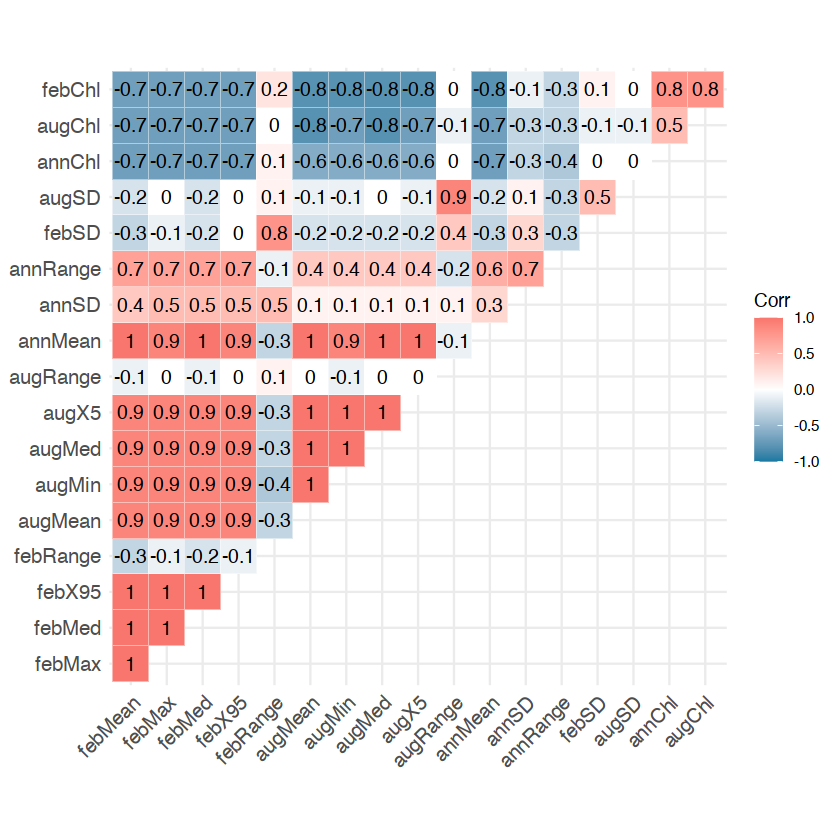

In [32]:
# Computing a correalation matrix
corr <- round(cor(env), 1)

# Visualization of our matrix
ggcorrplot(corr, type = 'upper', outline.col = "white",
          colors = c("#1679a1", "white", "#f8766d"),
          lab = TRUE)

Collinearity is rife in the dataset. Clearly there is a lot of reducdant information present. Using the VIF procedure we have [previously](https://github.com/ajsmit/Quantitative_Ecology/blob/main/jupyter_lab/Topic_12-Constrained_ordination.ipynb) arrived at seven environmental variables that best explain the seaweed flora community composition along the coast. Let's select the same ones here, standardize them, and produce an Euclidian distance matrix:

In [21]:
# all variables
E1_std <- decostand(E1, method = "standardize")
E1_euc <- vegdist(E1_std, method = "euclidean")

# variables selected by Smit et al. (2017)
E3 <- dplyr::select(env, febRange, febSD, augMean,
                    augRange, augSD, annRange, annSD)
E3_std <- decostand(E3, method = "standardize")
E3_euc <- vegdist(E3_std, method = "euclidean")

## Clustering

### Single linkage hierarchical clustering

Just to demonstrate that adding all those extra variables into the clustering algorithm does not result in any improvement on cluster resolution:

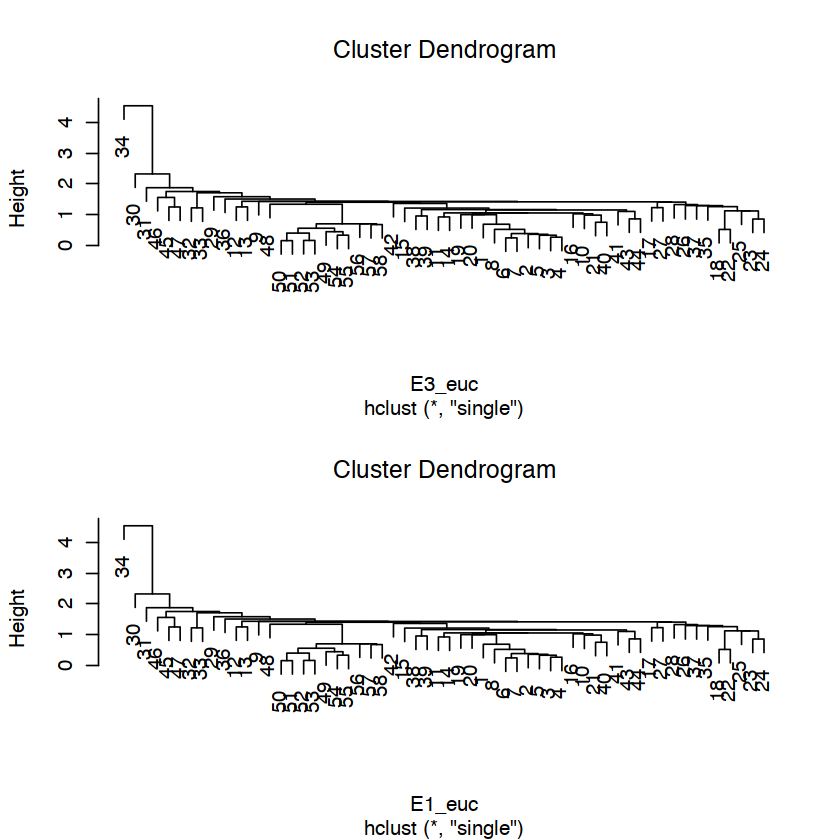

In [25]:
par(mfrow = c(2, 1))
E3_hc_s <- hclust(E3_euc, method = "single")
plot(E3_hc_s)
E1_hc_s <- hclust(E1_euc, method = "single")
plot(E1_hc_s)

Add some colour to the branches. Let's have four clusters. Why four? Thumb suck, maybe, but I was mostly motivated by the a priori manual clusffication by Bolton and Anderson (2004) and Smit et al. (2017).

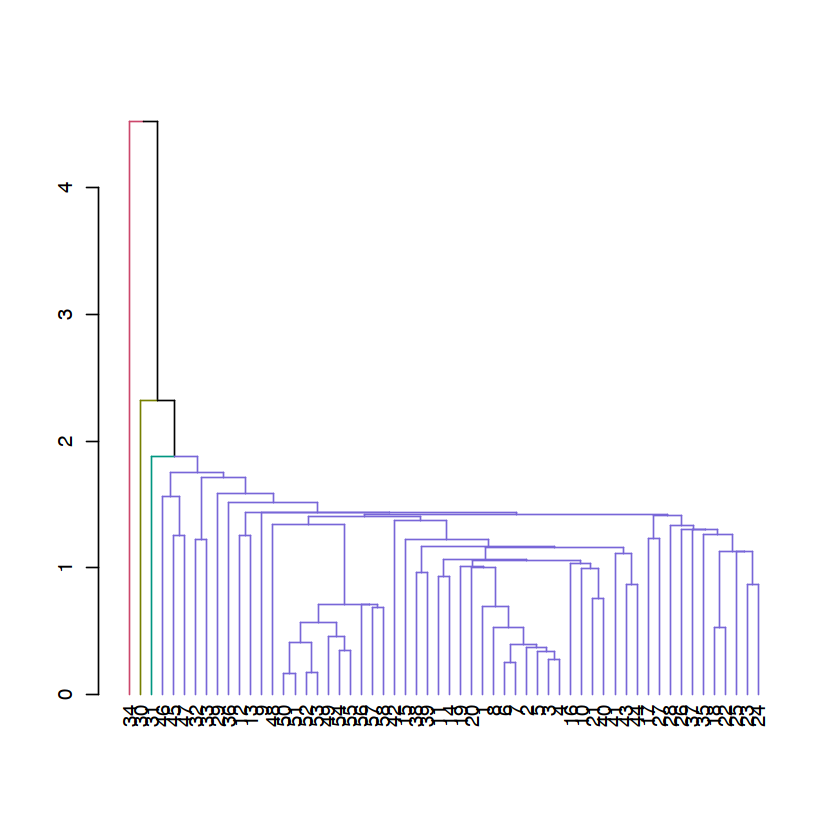

In [37]:
E3_hc_s <- color_branches(E3_hc_s, k = 4)
plot(E3_hc_s)

### Complete linkage hierarchical clustering

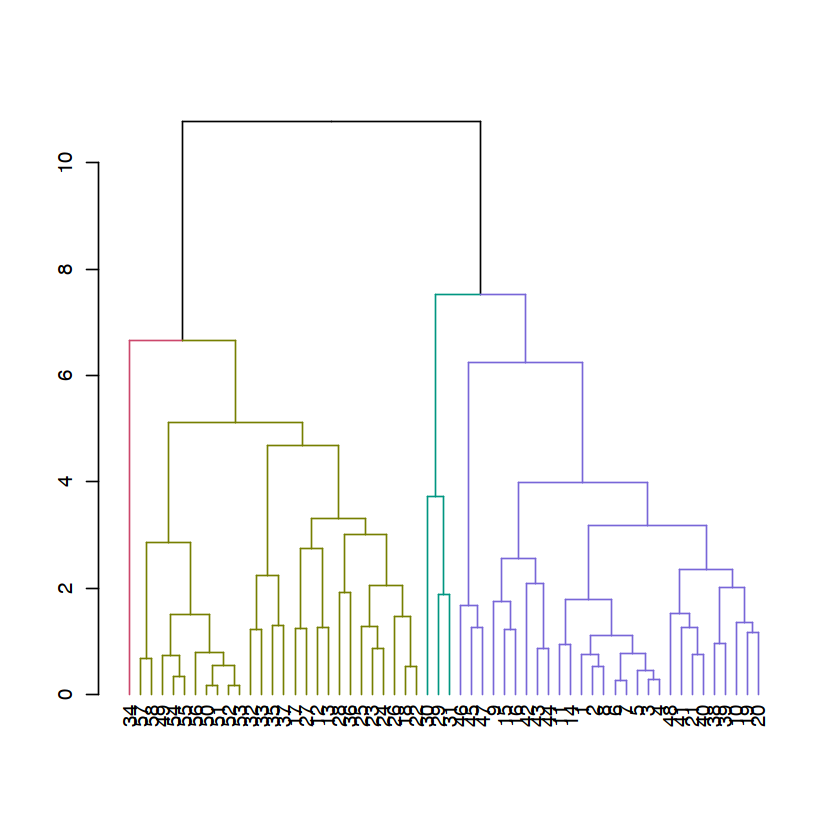

In [34]:
E3_hc_c <- hclust(E3_euc, method = "complete")
E3_hc_c <- color_branches(E3_hc_c, k = 4)
plot(E3_hc_c)

### Average agglomerative clustering

1. Unweighted Pair-Group Method using arithmetic Averages (UPGMA) “average”

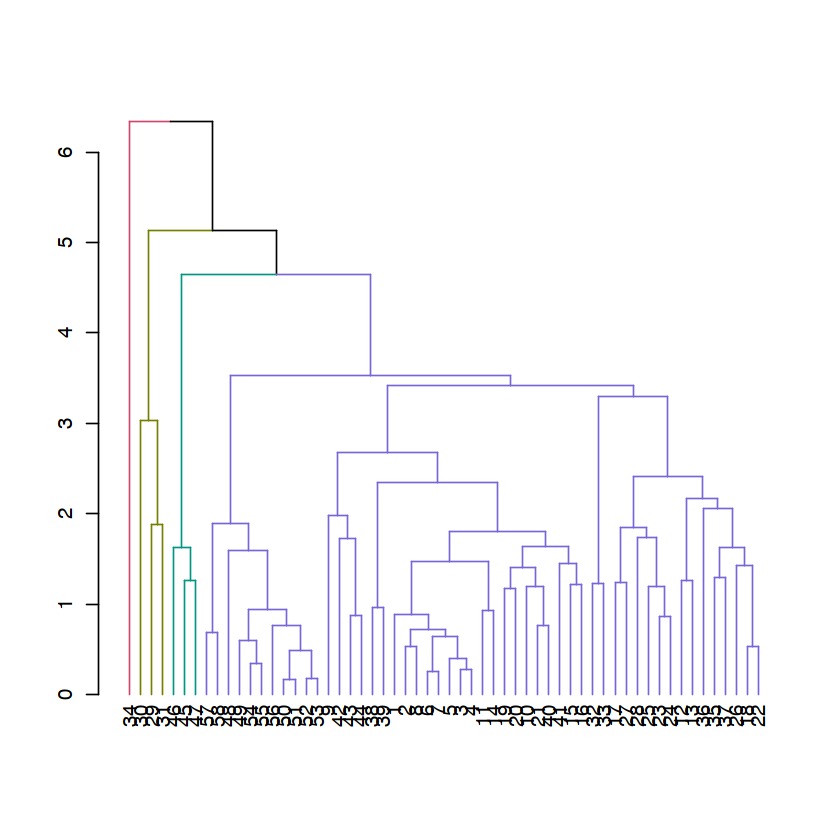

In [35]:
E3_hc_UPGMA <- hclust(E3_euc, method = "average")
E3_hc_UPGMA <- color_branches(E3_hc_UPGMA, k = 4)
plot(E3_hc_UPGMA)

2. Unweighted Pair-Group Method using Centroids (UPGMC) “centroid”

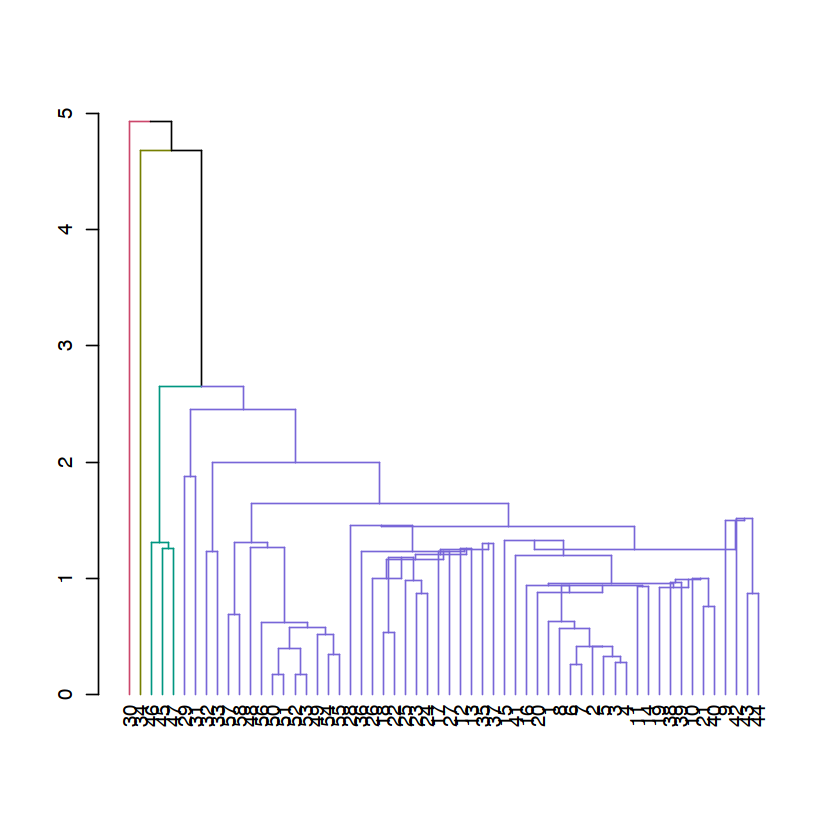

In [36]:
E3_hc_UPGMC <- hclust(E3_euc, method = "centroid")
E3_hc_UPGMC <- color_branches(E3_hc_UPGMC, k = 4)
plot(E3_hc_UPGMC)

3. Ward’s Minimum Variance Clustering

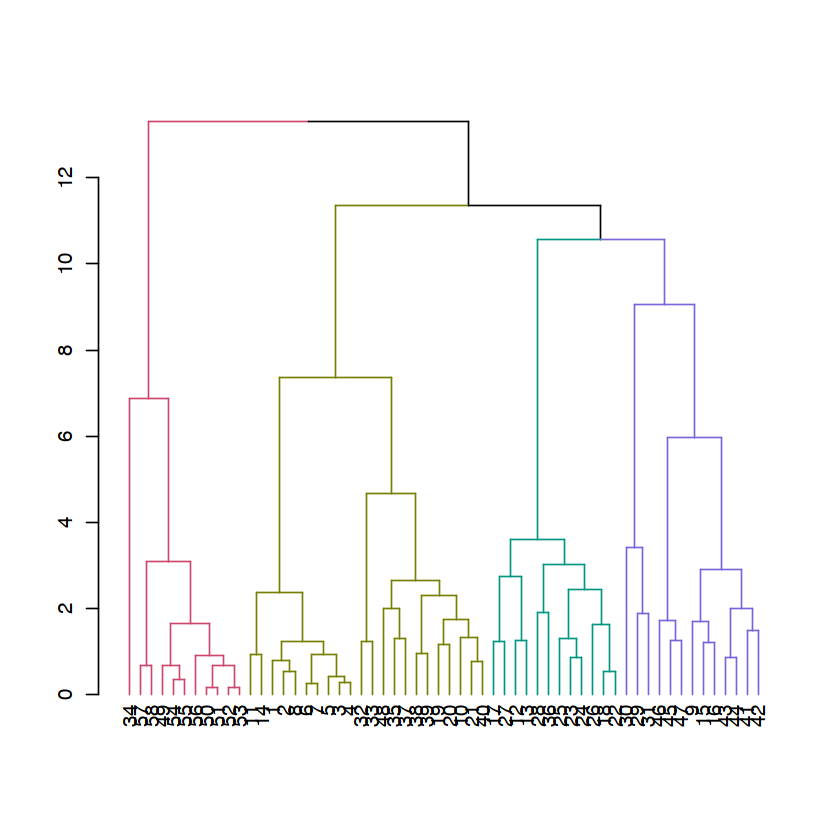

In [38]:
E3_hc_ward <- hclust(E3_euc, method = "ward.D2")
E3_hc_ward <- color_branches(E3_hc_ward, k = 4)
plot(E3_hc_ward)

### K-means clustering

In [50]:
E3_km <- kmeans(E3_std, centers = 4)
# plot(E3_km)
# E3_km_data <- E3_km$cluster # Saving saperate the cluster component
# data_kmeans3 <- mutate(data_df, group_kmeans = clust3_data) # Adding our clusters to the main data
# head(data_kmeans3)

In [54]:
fviz_screeplot(E3_km, addlabels = TRUE, ylim = c(0, 50))

ERROR: Error in get_eig(X): An object of class : kmeans can't be handled by the function get_eigenvalue()


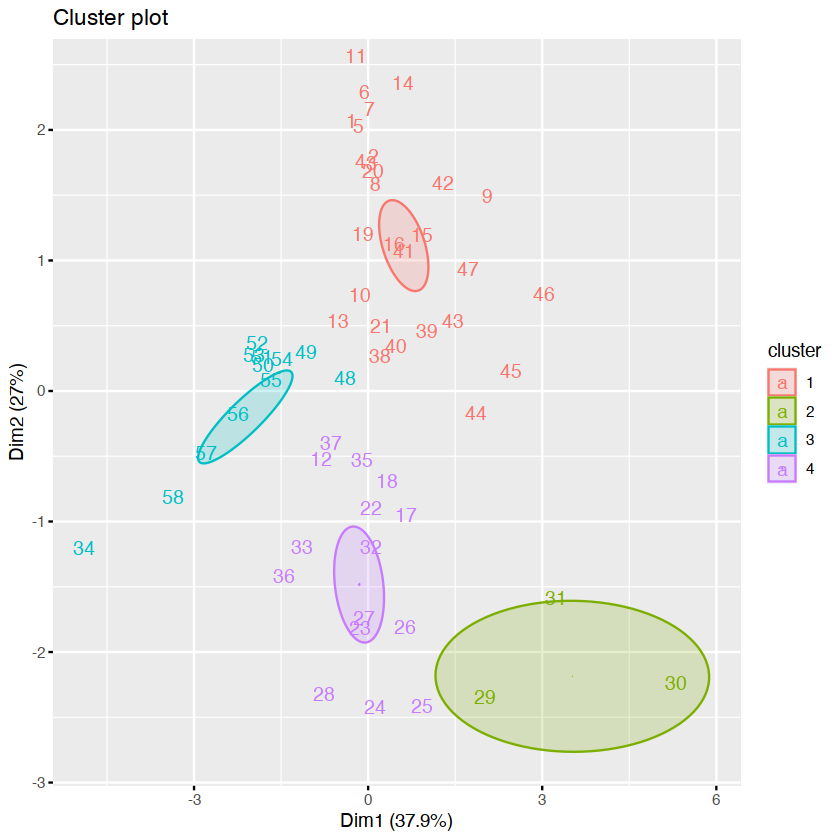

In [53]:
fviz_cluster(E3_km, data = E3_std,
             geom = "text",
             ellipse.type = "confidence",
             )